In [1]:
# Bismillahir Rahmaanir Raheem
# Almadadh Ya Gause Radi Allahu Ta'alah Anh - Ameen

## 1. Installation of Libraries

In [2]:
# Install Fast.ai library
!pip install -Uqq fastai

## 2. Importing Libraries

## 3. Set the Seed for Reproducibility

In [3]:
import numpy as np  # linear algebra and numerical operations
import random # for setting the random seed
import torch # for setting the torch random seed
from fastai.vision.all import *  # Fast.ai library for vision tasks
from pathlib import Path  # file path management
import os  # operating system interfaces
from IPython.display import display  # display utilities for Jupyter notebooks

In [4]:
random.seed(42) # Set the random seed for the random module
np.random.seed(42) # Set the random seed for numpy
torch.manual_seed(42) # Set the random seed for torch 
if torch.cuda.is_available(): # Check if CUDA (GPU) is available
    torch.cuda.manual_seed_all(42) # Set the random seed for all CUDA devices

## 4. Exploratory Data Analysis (EDA)

Contents of the dataset directory: ['chest_xray', '__MACOSX', 'val', 'test', 'train']

train set:
NORMAL: 1341 images
PNEUMONIA: 3875 images

val set:
NORMAL: 8 images
PNEUMONIA: 8 images

test set:
NORMAL: 234 images
PNEUMONIA: 390 images

Displaying sample images for category: NORMAL in path: ../input/chest-xray-pneumonia/chest_xray/train


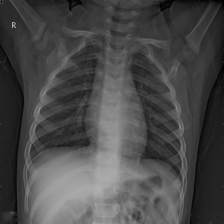

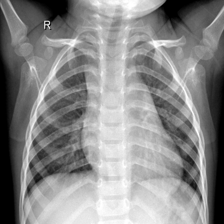

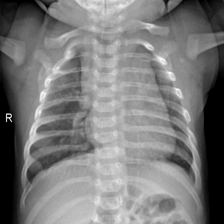


Displaying sample images for category: PNEUMONIA in path: ../input/chest-xray-pneumonia/chest_xray/train


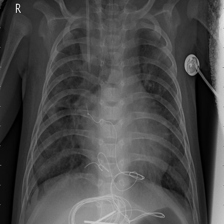

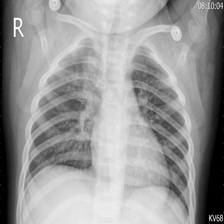

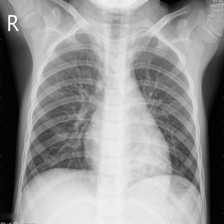

In [5]:
# Set the path to the dataset
path = Path('../input/chest-xray-pneumonia/chest_xray')  # Path to the root directory of the dataset

# Display the directory structure
print(f"Contents of the dataset directory: {os.listdir(path)}")  # Print the contents of the dataset directory

# Define the path to the training, validation, and test sets
train_path = path/'train'   # Path to the training set directory
valid_path = path/'val'     # Path to the validation set directory
test_path  = path/'test'    # Path to the test set directory

# Show the number of images in each category
for folder in [train_path, valid_path, test_path]:  # Iterate through training, validation, and test sets
    print(f"\n{folder.name} set:")  # Print the name of the current set
    for category in ['NORMAL', 'PNEUMONIA']:  # Iterate through the 'NORMAL' and 'PNEUMONIA' categories
        print(f"{category}: {len(os.listdir(folder/category))} images")  # Print the number of images in the current category

# Function to display sample images from each category
def show_sample_images(path, category, n=3, img_size=(224, 224)):  # Define function to show sample images
    print(f"\nDisplaying sample images for category: {category} in path: {path}")  # Print which category is being displayed
    images = (path/category).ls()[:n]  # Get a list of image paths in the specified category, up to n images
    for img_path in images:  # Iterate through the image paths
        img = Image.open(img_path)  # Open the image
        img = img.resize(img_size)  # Resize the image
        display(img)  # Display the image

# Display sample images from the training set
show_sample_images(train_path, 'NORMAL')  # Show sample images from the 'NORMAL' category in the training set
show_sample_images(train_path, 'PNEUMONIA')  # Show sample images from the 'PNEUMONIA' category in the training set

## 5. Data Preparation

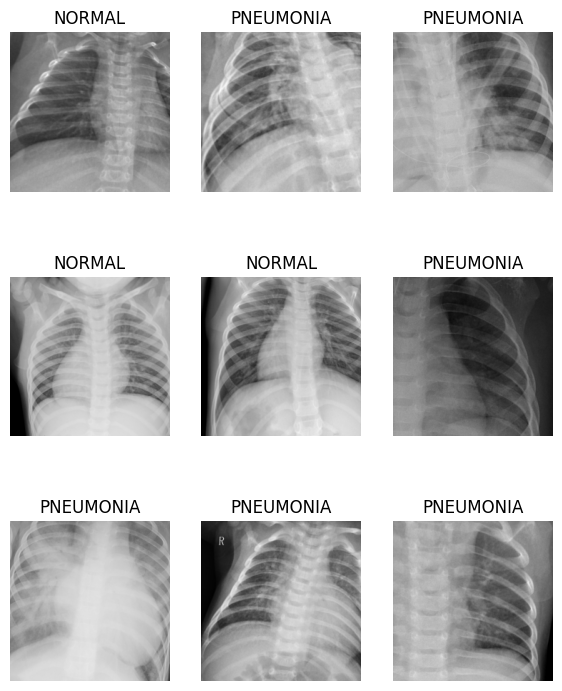

In [6]:
# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),            # Define the types of input (images) and output (categories/labels)
    get_items=get_image_files,                     # Function to get the list of image files
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),  # Split data into training and validation sets based on grandparent folder names, shuffle=True ensures data is shuffled
    get_y=parent_label,                            # Function to get labels from the parent directory names
    item_tfms=Resize(460),                         # Resize each image to 460x460 pixels as a transformation
    batch_tfms=aug_transforms(size=224, min_scale=0.75)  # Apply augmentations and resize to 224x224 pixels for each batch
)

# Create the DataLoaders
dls = dblock.dataloaders(path, bs=64) # Create DataLoaders with a batch size of 64, shuffle training data

# Enable shuffling of the training DataLoader
dls.train.shuffle = True

# Show a batch of training data
dls.show_batch(max_n=9, figsize=(7, 9)) # Display a batch of up to 9 images with the specified figure size

## 6. Model Training

In [7]:
# Initialize the learner with resnet34
# vision_learner: Constructs a learner suitable for vision tasks using a convolutional neural network
# dls: The DataLoaders object containing the training and validation data
# resnet34: The architecture of the neural network to be used (ResNet-34)
# metrics: The metrics to be monitored during training, in this case, accuracy
learn = vision_learner(dls, resnet34, metrics=accuracy)

# Train the model
# fine_tune: Fine-tunes the model by unfreezing the earlier layers and training for a few epochs
# 4: Number of epochs to train the model
learn.fine_tune(1)

# Save the trained model
# export: Exports the learner object to a file for later use
# 'pneumonia_model.pkl': The name of the file to save the model to
learn.export('pneumonia_model.pkl')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 158MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,0.319852,0.176403,0.875000,02:07


epoch,train_loss,valid_loss,accuracy,time
0,0.119116,0.142353,0.875000,01:58


## 7. Making Predictions

In [8]:
# Function to make predictions on a single image
def predict_image(img_path):
    img = PILImage.create(img_path)
    pred, pred_idx, probs = learn.predict(img)
    return dict(zip(learn.dls.vocab, map(float, probs)))

# Test the function with an example image for Pneumonia
example_image_pneumonia = test_path/'PNEUMONIA'/os.listdir(test_path/'PNEUMONIA')[0]
print(f"Prediction for {example_image_pneumonia}:")
print(predict_image(example_image_pneumonia))

print()
print()

# Test the function with an example image for Normal
example_image_normal = test_path/'NORMAL'/os.listdir(test_path/'NORMAL')[0]
print(f"Prediction for {example_image_normal}:")
print(predict_image(example_image_normal))

Prediction for ../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1676_virus_2892.jpeg:


{'NORMAL': 0.00950545072555542, 'PNEUMONIA': 0.9904944896697998}


Prediction for ../input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0336-0001.jpeg:


{'NORMAL': 0.9587864875793457, 'PNEUMONIA': 0.04121353104710579}
